In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
class RealIsisCubeLabelEncoder(pvl.encoder.IsisCubeLabelEncoder):    
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second

        time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time.encode('utf-8')

In [3]:
chan_file = '/home/arsanders/testData/chandrayaan/forwardDescending/input/M3G20081129T171431_V03_L1B.LBL'
image_file = chan_file

In [4]:
header = pvl.load(chan_file)

In [6]:
rdn_file = os.path.dirname(chan_file) + "/"+ header['RDN_FILE']['^RDN_IMAGE']
obs_file = os.path.dirname(chan_file) + "/"+ header['OBS_FILE']['^OBS_IMAGE']
loc_file = os.path.dirname(chan_file) + "/"+ header['LOC_FILE']['^LOC_IMAGE']
tab_file = os.path.dirname(chan_file) + "/"+ header['UTC_FILE']['^UTC_TIME_TABLE']

In [7]:
with open(rdn_file, 'rb') as f:
    # From the end, seek n_records * record_size backwards
    f.seek(-header['RDN_FILE']['RECORD_BYTES'] * header['RDN_FILE']['FILE_RECORDS'], 2)
    b_image_data = f.read()

In [8]:
n_lines = 5
line_length = header['RDN_FILE']['RDN_IMAGE']['LINE_SAMPLES'] * (header['RDN_FILE']['RDN_IMAGE']['SAMPLE_BITS']//8)

In [9]:
def read_chandrayaan(b_image_data, line_length, n_lines, n_bands):
    image_data = []
    for j in range(n_lines*n_bands):
        image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length],
                                     dtype=np.float32, count=int(line_length/4))
        image_data.append(image_sample)
    return np.array(image_data)

In [10]:
n_bands = header['RDN_FILE']['RDN_IMAGE']['BANDS']
n_output_bands = 3
image_data = read_chandrayaan(b_image_data, line_length, n_lines, n_bands)
cropped_image_data = image_data[np.where(np.arange(image_data.shape[0]) % n_bands < n_output_bands)]
#cropped_image_data = image_data

In [11]:
cropped_image_data.shape

(15, 304)

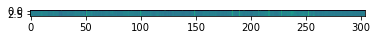

In [12]:
plt.imshow(cropped_image_data[0::n_output_bands])

In [13]:
with open(obs_file, 'rb') as f:
    # From the end, seek n_records * record_size backwards
    f.seek(-header['OBS_FILE']['RECORD_BYTES'] * header['OBS_FILE']['FILE_RECORDS'], 2)
    b_image_data = f.read()

In [14]:
n_bands = header['OBS_FILE']['OBS_IMAGE']['BANDS']
obs_image_data = read_chandrayaan(b_image_data, line_length, n_lines, n_bands)

In [15]:
obs_image_data.shape

(50, 304)

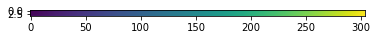

In [16]:
plt.imshow(obs_image_data[1::10])

In [17]:
with open(loc_file, 'rb') as f:
    # From the end, seek n_records * record_size backwards
    f.seek(-header['LOC_FILE']['RECORD_BYTES'] * header['LOC_FILE']['FILE_RECORDS'], 2)
    b_image_data = f.read()

In [18]:
line_length = header['LOC_FILE']['LOC_IMAGE']['LINE_SAMPLES'] * (header['LOC_FILE']['LOC_IMAGE']['SAMPLE_BITS']//8)
n_bands = header['LOC_FILE']['LOC_IMAGE']['BANDS']
image_data = []
for j in range(n_lines*n_bands):
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length],
                                 dtype=np.float64, count=int(line_length/8))
    image_data.append(image_sample)
loc_image_data = np.array(image_data)

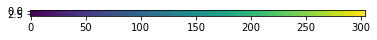

In [19]:
plt.imshow(loc_image_data[0::n_bands])

In [20]:
rdn_fn, rdn_ext = os.path.splitext(rdn_file)
obs_fn, obs_ext = os.path.splitext(obs_file)
loc_fn, loc_ext = os.path.splitext(loc_file)
tab_fn, tab_ext = os.path.splitext(tab_file)

mini_rdn_fn = rdn_fn + '_cropped' + rdn_ext
mini_rdn_bn = os.path.basename(mini_rdn_fn)

mini_obs_fn = obs_fn + '_cropped' + obs_ext
mini_obs_bn = os.path.basename(mini_obs_fn)

mini_loc_fn = loc_fn + '_cropped' + loc_ext
mini_loc_bn = os.path.basename(mini_loc_fn)

mini_tab_fn = tab_fn + '_cropped' + tab_ext
mini_tab_bn = os.path.basename(mini_tab_fn)


In [22]:
header['RDN_FILE']['^RDN_IMAGE'] = mini_rdn_bn
header['OBS_FILE']['^OBS_IMAGE'] = mini_obs_bn
header['LOC_FILE']['^LOC_IMAGE'] = mini_loc_bn
header['UTC_FILE']['^UTC_TIME_TABLE'] = mini_tab_bn

header['RDN_FILE']['FILE_RECORDS'] = n_lines
header['RDN_FILE']['RDN_IMAGE']['LINES'] = n_lines
header['RDN_FILE']['RDN_IMAGE']['BANDS'] = n_output_bands
header['RDN_FILE']['RECORD_BYTES'] = int(n_output_bands * (header['RDN_FILE']['RDN_IMAGE']['SAMPLE_BITS']/8) *header['RDN_FILE']['RDN_IMAGE']['LINE_SAMPLES'])

header['LOC_FILE']['FILE_RECORDS'] = n_lines
header['LOC_FILE']['LOC_IMAGE']['LINES'] = n_lines

header['OBS_FILE']['FILE_RECORDS'] = n_lines
header['OBS_FILE']['OBS_IMAGE']['LINES'] = n_lines

header['UTC_FILE']['FILE_RECORDS'] = n_lines
header['UTC_FILE']['UTC_TIME_TABLE']['ROWS'] = n_lines

In [27]:
label_fn, label_ext = os.path.splitext(chan_file)
out_label = label_fn + '_cropped' + label_ext
pvl.dump(header, out_label, cls=RealIsisCubeLabelEncoder)

In [28]:
with open(mini_rdn_fn, 'wb+') as f:
    b_reduced_image_data = cropped_image_data.tobytes()
    f.seek(0, 2)
    f.write(b_reduced_image_data)

In [29]:
with open(mini_loc_fn, 'wb+') as f:
    b_reduced_image_data = loc_image_data.tobytes()
    f.seek(0, 2)
    f.write(b_reduced_image_data)

In [30]:
with open(mini_obs_fn, 'wb+') as f:
    b_reduced_image_data = obs_image_data.tobytes()
    f.seek(0, 2)
    f.write(b_reduced_image_data)

In [31]:
with open(tab_file) as f:
    head = [next(f) for x in range(n_lines)]
    head = "".join(head)
with open(mini_tab_fn, 'w+') as f:
    f.write(head)